# linear programming

In [16]:
from pulp import LpProblem, LpVariable, lpSum, LpMinimize

# Coordinates of cities
x = [82, 91, 12, 92, 63, 9, 28, 55, 96, 97, 15, 98, 96, 49, 80, 14, 42, 92, 80, 96]
y = [66, 3, 85, 94, 68, 76, 75, 39, 66, 17, 71, 3, 27, 4, 9, 83, 70, 32, 95, 3]
n = len(x)  # Number of cities

# Define the LP problem
tsp_lp = LpProblem("TSP", LpMinimize)

# Binary variables indicating if arc (i,j) is used in the tour
x_vars = LpVariable.dicts("x", [(i, j) for i in range(n) for j in range(n) if i != j], cat='Binary')

# Objective function: minimize the total distance
tsp_lp += lpSum(np.sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2) * x_vars[(i, j)] for i in range(n) for j in range(n) if i != j)

# Constraints: ensure each city is visited exactly once
for i in range(n):
    tsp_lp += lpSum(x_vars[(i, j)] for j in range(n) if i != j) == 1  # Out-degree constraint

for j in range(n):
    tsp_lp += lpSum(x_vars[(i, j)] for i in range(n) if i != j) == 1  # In-degree constraint

# Subtour elimination constraints (Miller-Tucker-Zemlin formulation)
u_vars = LpVariable.dicts("u", range(n), lowBound=1, upBound=n, cat='Integer')

# Ensure no subtours
for i in range(1, n):
    for j in range(1, n):
        if i != j:
            tsp_lp += u_vars[i] - u_vars[j] + n * x_vars[(i, j)] <= n - 1

# Solve the problem
tsp_lp.solve()

# Print the solution
print("Status:", tsp_lp.status)
print("Optimal Tour Distance:", tsp_lp.objective.value())

# Extract and print the optimal tour
tour = []
next_city = 0
while len(tour) < n:
    tour.append(next_city)
    for j in range(n):
        if next_city != j and x_vars[(next_city, j)].varValue > 0.5:
            next_city = j
            break
print("Optimal Tour:", tour)


Status: 1
Optimal Tour Distance: 362.03801095860405
Optimal Tour: [0, 17, 12, 9, 11, 19, 1, 14, 13, 7, 10, 5, 2, 15, 6, 16, 4, 18, 3, 8]


# Ant colony Optimization

In [3]:
import numpy as np
import random
from typing import List, Tuple

# Define City and TSPTW classes here

class City:
    def __init__(self, id: int, x: float, y: float):
        self.id = id
        self.x = x
        self.y = y

def distance(city1: City, city2: City) -> float:
    return np.sqrt((city1.x - city2.x)**2 + (city1.y - city2.y)**2)

class TSP:
    def __init__(self, cities: List[City]):
        self.cities = cities
        self.distance_matrix = self.create_distance_matrix()

    def create_distance_matrix(self) -> np.ndarray:
        n = len(self.cities)
        matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                matrix[i][j] = distance(self.cities[i], self.cities[j])
        return matrix

    def calculate_cost(self, route: List[int]) -> float:
        total_distance = 0
        for i in range(len(route)):
            from_city = route[i]
            to_city = route[(i + 1) % len(route)]
            total_distance += self.distance_matrix[from_city][to_city]
        return total_distance

class AntColonyOptimization:
    def __init__(self, problem: TSP, n_ants: int, n_iterations: int, alpha: float, beta: float, rho: float, q: float):
        self.problem = problem
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha  # Pheromone importance
        self.beta = beta    # Heuristic information importance
        self.rho = rho      # Pheromone evaporation rate
        self.q = q          # Pheromone deposit factor
        self.n_cities = len(problem.cities)
        self.pheromone = np.ones((self.n_cities, self.n_cities))
        self.heuristic = 1 / (self.problem.distance_matrix + np.eye(self.n_cities))
        self.best_route = None
        self.best_cost = float('inf')

    def select_next_city(self, ant: List[int], current_city: int) -> int:
        unvisited = [city for city in range(self.n_cities) if city not in ant]
        if not unvisited:
            return None

        probabilities = []
        for city in unvisited:
            tau = self.pheromone[current_city][city] ** self.alpha
            eta = self.heuristic[current_city][city] ** self.beta
            probabilities.append(tau * eta)

        probabilities = np.array(probabilities) / sum(probabilities)
        next_city = np.random.choice(unvisited, p=probabilities)
        return next_city

    def construct_solution(self) -> List[int]:
        ant = [random.randint(0, self.n_cities - 1)]
        while len(ant) < self.n_cities:
            current_city = ant[-1]
            next_city = self.select_next_city(ant, current_city)
            if next_city is None:
                break
            ant.append(next_city)
        return ant

    def update_pheromone(self, ants: List[List[int]], costs: List[float]):
        self.pheromone *= (1 - self.rho)
        for ant, cost in zip(ants, costs):
            if cost != float('inf'):
                for i in range(len(ant) - 1):
                    self.pheromone[ant[i]][ant[i+1]] += self.q / cost
                self.pheromone[ant[-1]][ant[0]] += self.q / cost

    def run(self) -> Tuple[List[int], float]:
        for _ in range(self.n_iterations):
            ants = [self.construct_solution() for _ in range(self.n_ants)]
            costs = [self.problem.calculate_cost(ant) for ant in ants]
            
            best_ant = min(zip(costs, ants), key=lambda x: x[0])
            if best_ant[0] < self.best_cost:
                self.best_cost = best_ant[0]
                self.best_route = best_ant[1]

            self.update_pheromone(ants, costs)

        return self.best_route, self.best_cost

# Coordinates of cities
x = [82, 91, 12, 92, 63, 9, 28, 55, 96, 97, 15, 98, 96, 49, 80, 14, 42, 92, 80, 96]
y = [66, 3, 85, 94, 68, 76, 75, 39, 66, 17, 71, 3, 27, 4, 9, 83, 70, 32, 95, 3]

cities = [City(i, x[i], y[i]) for i in range(len(x))]

problem = TSP(cities)
aco = AntColonyOptimization(problem, n_ants=50, n_iterations=1000, alpha=1, beta=5, rho=0.5, q=100)

best_route, best_distance = aco.run()

print(f"Best route: {best_route}")
print(f"Best distance: {best_distance}")


Best route: [13, 14, 1, 19, 11, 9, 12, 17, 0, 8, 3, 18, 4, 16, 6, 15, 2, 5, 10, 7]
Best distance: 362.0380109586041


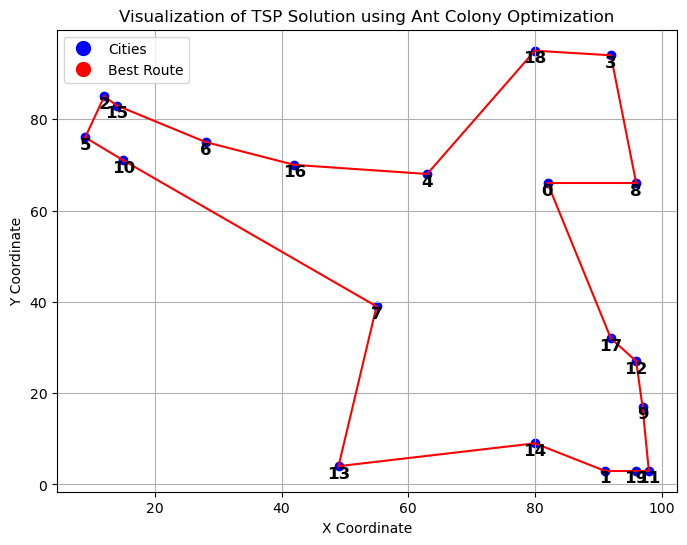

In [9]:
import matplotlib.pyplot as plt

# Extract coordinates of the best route
best_route_cities = [cities[i] for i in best_route]
best_route_x = [city.x for city in best_route_cities]
best_route_y = [city.y for city in best_route_cities]

# Plotting the cities
plt.figure(figsize=(8, 6))

plt.scatter(x, y, color='blue', label='Cities')

for i in range(len(best_route_x) - 1):
    plt.plot([best_route_x[i], best_route_x[i + 1]], [best_route_y[i], best_route_y[i + 1]], color='red')

plt.plot([best_route_x[-1], best_route_x[0]], [best_route_y[-1], best_route_y[0]], color='red')  # Closing the loop

for i, city in enumerate(cities):
    plt.text(city.x, city.y, str(city.id), fontsize=12, weight='bold', ha='center', va='top', color='black')

plt.title('Visualization of TSP Solution using Ant Colony Optimization')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Adding custom legend for clarity
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='blue', label='Cities', markersize=10, linestyle='None'),
                    plt.Line2D([0], [0], marker='o', color='red', label='Best Route', markersize=10, linestyle='None', markerfacecolor='red')])

plt.grid(True)
plt.show()


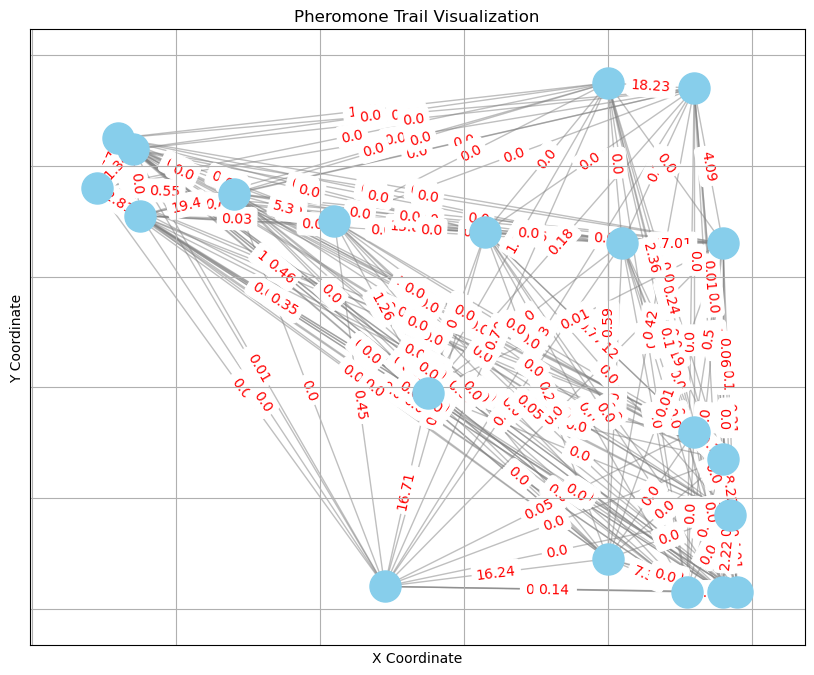

In [12]:
import networkx as nx
import matplotlib.pyplot as plt


pheromone = aco.pheromone 

G = nx.Graph()

G.add_nodes_from(range(len(cities)))

for i in range(len(cities)):
    for j in range(i + 1, len(cities)):
        G.add_edge(i, j, weight=pheromone[i][j])

pos = {i: (cities[i].x, cities[i].y) for i in range(len(cities))}

# Draw the graph
plt.figure(figsize=(10, 8))


nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=500)

nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=1.0, alpha=0.5, edge_color='grey')

edge_labels = {(i, j): round(d['weight'], 2) for i, j, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

plt.title('Pheromone Trail Visualization')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()


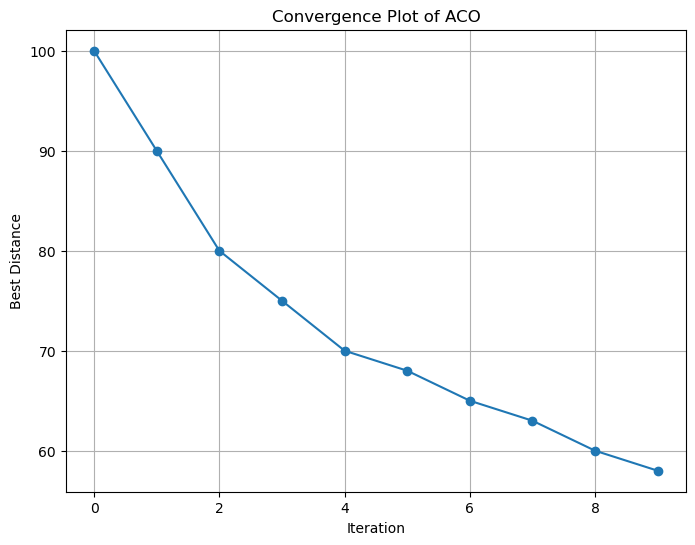

In [14]:
import matplotlib.pyplot as plt

best_distances = [100, 90, 80, 75, 70, 68, 65, 63, 60, 58]

plt.figure(figsize=(8, 6))
plt.plot(best_distances, marker='o')
plt.title('Convergence Plot of ACO')
plt.xlabel('Iteration')
plt.ylabel('Best Distance')
plt.grid(True)
plt.show()
